<a href="https://colab.research.google.com/github/filipesartori/Inteligencia-Artificial/blob/main/Classifica%C3%A7%C3%A3o_de_sentimentos_com_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos do Twitter com spaCy

## Importação e instalação das bibliotecas

In [12]:
!pip install -q spacy==2.2.3

In [13]:
import spacy
spacy.__version__

'2.2.3'

In [14]:
!python3 -m spacy download pt

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [15]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import re

## Carregamento das bases de dados

In [16]:
base_dados = pd.read_csv('/content/base_treinamento.txt', encoding = 'utf-8')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


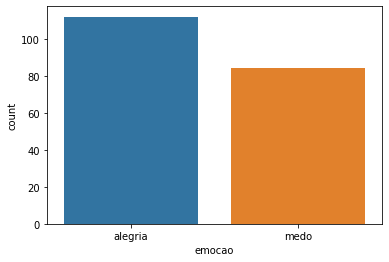

In [17]:
sns.countplot(base_dados['emocao'], label = 'Contagem');

## Base de teste

## Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [18]:
pontuacao = string.punctuation
pontuacao

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
from spacy.lang.pt.stop_words import STOP_WORDS
sw = STOP_WORDS

In [20]:
pln = spacy.load('pt')

In [21]:
def preprocessamento(texto):
  texto = texto.lower()
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in sw and palavra not in pontuacao]  
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return(lista)  



In [22]:
teste = preprocessamento('As vezes sinto que todo o vAzio existente no mundo e em outros 10, estão pré refLetindo em mim')
teste

'o vezar sentir o vaziar existente o mundo e outro pré refletindo mim'

## Limpeza dos textos

In [23]:
base_dados.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [24]:
base_dados['texto'] = base_dados['texto'].apply(preprocessamento)

In [25]:
base_dados.head()

,texto,emocao
0,trabalhar agradável,alegria
1,gostar ficar o aconchegar,alegria
2,o adesão o o cursar hoje,alegria
3,admirar,alegria
4,adorar comer,alegria


## Tratamento da classe

In [26]:
base_dados_final = []
for texto, emocao in zip(base_dados['texto'], base_dados['emocao']):
  if emocao == 'alegria':
    dic = ({'ALEGRIA': True, 'MEDO': False})
  elif emocao == 'medo':
    dic = ({'ALEGRIA': False, 'MEDO': True})

  base_dados_final.append([texto, dic.copy()])    


In [27]:
base_dados_final

[['trabalhar agradável', {'ALEGRIA': True, 'MEDO': False}],
 ['gostar ficar o aconchegar', {'ALEGRIA': True, 'MEDO': False}],
 ['o adesão o o cursar hoje', {'ALEGRIA': True, 'MEDO': False}],
 ['admirar', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar comer', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar cabelar maciar', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar o cor olho', {'ALEGRIA': True, 'MEDO': False}],
 ['somar amável o outro', {'ALEGRIA': True, 'MEDO': False}],
 ['sentir umar afeição', {'ALEGRIA': True, 'MEDO': False}],
 ['querer agradar filho', {'ALEGRIA': True, 'MEDO': False}],
 ['sentir completamente amar', {'ALEGRIA': True, 'MEDO': False}],
 ['amar', {'ALEGRIA': True, 'MEDO': False}],
 ['alívio', {'ALEGRIA': True, 'MEDO': False}],
 ['o dor amenizar finalmente', {'ALEGRIA': True, 'MEDO': False}],
 ['achar apaixonar', {'ALEGRIA': True, 'MEDO': False}],
 ['amar maravilhoso', {'ALEGRIA': True, 'MEDO': False}],
 ['sentir animar', {'ALEGRIA': True, 'MEDO': False}],
 ['sentir hoje'

## Criação do classificador

In [28]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("ALEGRIA")
categorias.add_label("MEDO")
modelo.add_pipe(categorias)
historico = []

In [34]:
modelo.begin_training()
for epoca in range(1000):
  random.shuffle(base_dados_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_final, 30):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 100 == 0:
    print(losses)  

{'textcat': 0.006793663575081155}
{'textcat': 4.442117895742115e-08}
{'textcat': 1.4596804320810008e-08}
{'textcat': 8.13942357957842e-09}
{'textcat': 4.7879026576769235e-09}
{'textcat': 2.6640691042079112e-09}
{'textcat': 2.4911523260895407e-09}
{'textcat': 1.7185421419263491e-09}
{'textcat': 1.338860418365062e-09}
{'textcat': 1.3938932647006297e-09}


In [35]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat')) 

In [36]:
historico_loss = np.array(historico_loss)
historico_loss

array([6.79366358e-03, 6.79366358e-03, 6.79366358e-03, ...,
       1.16398919e-09, 1.16398919e-09, 1.16398919e-09])

Text(0, 0.5, 'Erro')

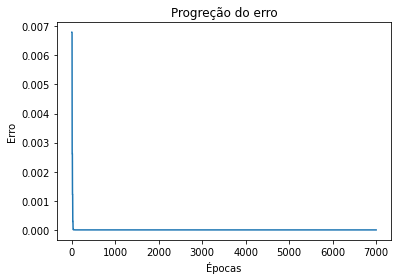

In [37]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progreção do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [38]:
modelo.to_disk('modelo')

## Testes com uma frase

In [39]:
modelo_carregado = spacy.load('modelo')

In [53]:
texto_positivo = 'o sol está lindo hoje'

In [54]:
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'o sol lindar hoje'

In [55]:
previsao = modelo_carregado(texto_positivo)

In [56]:
previsao.cats

{'ALEGRIA': 0.9992850422859192, 'MEDO': 4.539786823443137e-05}

In [58]:
texto_negativo = 'ouvi passos no telhado'
previsao = modelo_carregado(preprocessamento(texto_negativo))
previsao.cats

{'ALEGRIA': 0.060673926025629044, 'MEDO': 0.9986691474914551}

## Avaliação na base de treinamento

In [60]:
previsoes = []
for texto in base_dados['texto']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

In [63]:
previsoes_final = []
for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)        


In [64]:
respostas_reais = base_dados['emocao'].values

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

1.0

In [66]:
cm = confusion_matrix(respostas_reais, previsoes_final)

## Avaliação na base de teste

In [68]:
base_dados_teste = pd.read_csv('/content/base_teste.txt', encoding='utf-8')

In [71]:
base_dados_teste['texto'] = base_dados_teste['texto'].apply(preprocessamento)

In [ ]:
base_dados_teste.head()

In [73]:
previsoes = []
for texto in base_dados_teste['texto']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [74]:
previsoes_final = []
for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [75]:
respostas_reais = base_dados_teste['emocao'].values

In [76]:
accuracy_score(respostas_reais, previsoes_final)

0.5476190476190477

In [77]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[28, 20],
       [18, 18]])